In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
from src.loader import load_dataset
from src.models import SRR
from src.preprocessing import processing_pipeline
from src.feature_selection import forward_stepwise_regression
from src.vulnerabilities import find_adversarial_examples

## Plot of Adversarial examples

### IEEE-CIS

In [3]:
dataset = 'ieeecis'
print(f"-> {dataset} dataset")
# Load the data
X, y = load_dataset(name=dataset)

-> ieeecis dataset
Loading ieeecis...


In [4]:
# This datasets is too big so get a reasonably-sized subset
X_subset = pd.concat([X[y == 1].sample(n=1500, random_state=15),
                      X[y == 0].sample(n=1500, random_state=15)])
y_subset = y.loc[X_subset.index]

# Apply the processing pipeline
X_train, X_test, y_train, y_test = processing_pipeline(X_subset, y_subset, nbins=3)

# Construct and train Select-Regress-Round model
srr = SRR(k=3, M=5)
srr.fit(X_train, y_train)

srr.show_scoring_table()

Select-Regress-Round (SRR) [k=3, M=5]

        Feature            Category  Score
        browser     android webview      2
        browser  chrome for android      2
        browser                edge     -2
        browser             firefox     -1
        browser      ie for desktop     -3
        browser       ie for tablet     -2
        browser               opera      5
        browser               other      1
        browser              safari     -2
        browser     samsung browser      1
        browser             unknown     -2
      card_type              credit      1
      card_type                 nan     -2
 TransactionAmt      (108.476, inf]      1

Intercept: 0

Predict class 1 if sum of scores and intercept is >= 0, otherwise predict 0.


In [5]:
adversaries = find_adversarial_examples(srr, X_train, y_train,
                                        can_change=['browser'], unit_changes=True)

Found adversarial examples for 100.00 % of the correctly classified points


In [6]:
feat = 'browser'
df = adversaries['original'].copy()
df['original'] = df[feat]
df['new'] = adversaries['new'][feat]

df = df.groupby(['label', 'original', 'new']).size().reset_index().rename(columns={0: 'count'})
df.replace({'label': {0: 'legit -> fraud', 1: 'fraud -> legit'}}, inplace=True)
df.columns = ['label change'] + list(df.columns[1:])
df

,label change,original,new,count
0,legit -> fraud,edge,android webview,14
1,legit -> fraud,edge,chrome,14
2,legit -> fraud,edge,chrome for android,14
3,legit -> fraud,edge,chrome for ios,14
4,legit -> fraud,edge,firefox,11
...,...,...,...,...
112,fraud -> legit,samsung browser,ie for desktop,12
113,fraud -> legit,samsung browser,ie for tablet,5
114,fraud -> legit,samsung browser,safari,5
115,fraud -> legit,samsung browser,unknown,5


In [7]:
fraud_legit = df[df['label change'] == 'fraud -> legit'].pivot_table(index='original', columns='new', values='count')
legit_fraud = df[df['label change'] == 'legit -> fraud'].pivot_table(index='original', columns='new', values='count')

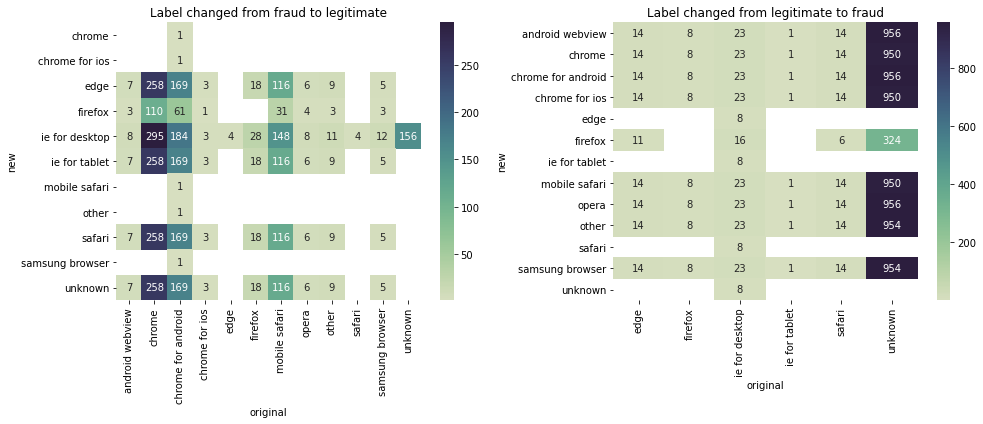

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((14, 6))

sns.heatmap(fraud_legit.T, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), annot=True, ax=ax1, fmt='g')
ax1.set_title('Label changed from fraud to legitimate')

sns.heatmap(legit_fraud.T, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), annot=True, ax=ax2, fmt='g')
ax2.set_title('Label changed from legitimate to fraud')

fig.set_tight_layout(True);

### german_credit

In [13]:
dataset = 'german_credit'
print(f"-> {dataset} dataset")
# Load the data
X, y = load_dataset(name=dataset)
# Apply the processing pipeline
X_train, X_test, y_train, y_test = processing_pipeline(X, y, nbins=5)

# Construct and train Select-Regress-Round model
srr = SRR(k=5, M=5)
srr.fit(X_train, y_train)

srr.show_scoring_table()

-> german_credit dataset
Loading german_credit...
Select-Regress-Round (SRR) [k=5, M=5]

                    Feature                                                     Category  Score
 Status_of_checking_account                                                   ... < 0 DM     -3
 Status_of_checking_account       ... >= 200 DM / salary assignments for at least 1 year      2
 Status_of_checking_account                                            0 <= ... < 200 DM     -1
 Status_of_checking_account                                          no checking account      4
             Credit_history                      all credits at this bank paid back duly     -3
             Credit_history  critical account/ other credits existing (not at this bank)      3
             Credit_history                              delay in paying off in the past      1
             Credit_history                 no credits taken/ all credits paid back duly     -3
              Credit_amount                    

In [14]:
def str_to_interval(string):
    low, high = map(float, string[1:-1].split(','))
    return pd.Interval(left=low, right=high)

def srr_interval_feat_to_rank(srr, feat):
    return dict(map(reversed, srr.df.loc[feat].index.to_series().reset_index(drop=True).map(str_to_interval).to_dict().items()))

In [17]:
month_map = srr_interval_feat_to_rank(srr, 'Duration_in_months')
month_map

{Interval(-inf, 11.5, closed='right'): 0,
 Interval(11.5, 20.0, closed='right'): 1,
 Interval(20.0, 29.0, closed='right'): 2,
 Interval(29.0, inf, closed='right'): 3}

In [18]:
amount_map = srr_interval_feat_to_rank(srr, 'Credit_amount')
amount_map

{Interval(-inf, 1401.0, closed='right'): 0,
 Interval(1401.0, 2382.0, closed='right'): 1,
 Interval(2382.0, 4053.0, closed='right'): 2,
 Interval(4053.0, inf, closed='right'): 3}

In [7]:
advs = find_adversarial_examples(model, X_train_bin, y_train, 
                                 can_change=['Credit_amount', 'Purpose', 'Duration_in_months'], unit_changes=False)
advs

100%|██████████| 686/686 [12:56<00:00,  1.13s/it]


new                                                     \
      Credit_amount                                     Credit_history   
1    (-inf, 1401.0]           existing credits paid back duly till now   
1    (-inf, 1401.0]           existing credits paid back duly till now   
1    (-inf, 1401.0]           existing credits paid back duly till now   
1    (-inf, 1401.0]           existing credits paid back duly till now   
1    (-inf, 1401.0]           existing credits paid back duly till now   
..              ...                                                ...   
999   (4053.0, inf]  critical account/ other credits existing (not ...   
999   (4053.0, inf]  critical account/ other credits existing (not ...   
999   (4053.0, inf]  critical account/ other credits existing (not ...   
999   (4053.0, inf]  critical account/ other credits existing (not ...   
999   (4053.0, inf]  critical account/ other credits existing (not ...   

                                                                              \
    Duration_in_months              Purpose Status_of_checking_account label   
1         (11.5, 20.0]             business          0 <= ... < 200 DM     1   
1         (11.5, 20.0]  furniture/equipment          0 <= ... < 200 DM     1   
1         (11.5, 20.0]     radio/television          0 <= ... < 200 DM     1   
1         (11.5, 20.0]           car (used)          0 <= ... < 200 DM     1   
1         (11.5, 20.0]           retraining          0 <= ... < 200 DM     1   
..                 ...                  ...                        ...   ...   
999       (20.0, 29.0]              repairs          0 <= ... < 200 DM     0   
999       (20.0, 29.0]            education          0 <= ... < 200 DM     0   
999        (29.0, inf]            car (new)          0 <= ... < 200 DM     0   
999        (29.0, inf]              repairs          0 <= ... < 200 DM     0   
999        (29.0, inf]            education          0 <= ... < 200 DM     0   

          original                                                     \
     Credit_amount                                     Credit_history   
1    (4053.0, inf]           existing credits paid back duly till now   
1    (4053.0, inf]           existing credits paid back duly till now   
1    (4053.0, inf]           existing credits paid back duly till now   
1    (4053.0, inf]           existing credits paid back duly till now   
1    (4053.0, inf]           existing credits paid back duly till now   
..             ...                                                ...   
999  (4053.0, inf]  critical account/ other credits existing (not ...   
999  (4053.0, inf]  critical account/ other credits existing (not ...   
999  (4053.0, inf]  critical account/ other credits existing (not ...   
999  (4053.0, inf]  critical account/ other credits existing (not ...   
999  (4053.0, inf]  critical account/ other credits existing (not ...   

                                                                           
    Duration_in_months           Purpose Status_of_checking_account label  
1          (29.0, inf]  radio/television          0 <= ... < 200 DM     0  
1          (29.0, inf]  radio/television          0 <= ... < 200 DM     0  
1          (29.0, inf]  radio/television          0 <= ... < 200 DM     0  
1          (29.0, inf]  radio/television          0 <= ... < 200 DM     0  
1          (29.0, inf]  radio/television          0 <= ... < 200 DM     0  
..                 ...               ...                        ...   ...  
999        (29.0, inf]        car (used)          0 <= ... < 200 DM     1  
999        (29.0, inf]        car (used)          0 <= ... < 200 DM     1  
999        (29.0, inf]        car (used)          0 <= ... < 200 DM     1  
999        (29.0, inf]        car (used)          0 <= ... < 200 DM     1  
999        (29.0, inf]        car (used)          0 <= ... < 200 DM     1  

[20919 rows x 12 columns]

## [new] Show number of examples as a function of the number of changes.

In [10]:
df = pd.DataFrame(dtype=int)
df['number of simultaneous changes'] = (advs['new'].drop(columns='label') != advs['original'].drop(columns='label')) \
                                .astype(int).sum(axis=1)
df['label change'] = advs['original']['label'].replace({0: 'bad -> good', 1: 'good -> bad'})
df

,number of simultaneous changes,label change
1,3,bad -> good
1,3,bad -> good
1,2,bad -> good
1,3,bad -> good
1,3,bad -> good
...,...,...
999,2,good -> bad
999,2,good -> bad
999,1,good -> bad
999,1,good -> bad


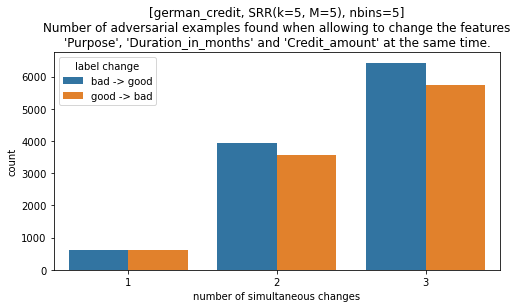

In [19]:
ax = sns.countplot(x='number of simultaneous changes', hue='label change', data=df)

ax.figure.set_size_inches((8, 4))
ax.set_title(
    "[german_credit, SRR(k=5, M=5), nbins=5]\n"
    "Number of adversarial examples found when allowing to change the features\n'Purpose', 'Duration_in_months' and 'Credit_amount' at the same time."
);

## Plot of interval change for all features

##### Plot of maximum Credit_amount increase while changing Purpose

In [9]:
df = advs['original'].copy()

df['new Purpose'] = advs['new']['Purpose']
df['Credit change'] = advs['new']['Credit_amount'].map(amount_map) \
                    - advs['original']['Credit_amount'].map(amount_map).astype(int)


df.replace({'label': {0: 'bad -> good', 1: 'good -> bad'}}, inplace=True)
df

,Credit_amount,Credit_history,Duration_in_months,Purpose,Status_of_checking_account,label,new Purpose,Credit change
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,car (new),-1
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,business,-2
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,business,-1
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,furniture/equipment,-2
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,furniture/equipment,-1
...,...,...,...,...,...,...,...,...
999,"(4053.0, inf]",critical account/ other credits existing (not ...,"(29.0, inf]",car (used),0 <= ... < 200 DM,good -> bad,car (new),0
999,"(4053.0, inf]",critical account/ other credits existing (not ...,"(29.0, inf]",car (used),0 <= ... < 200 DM,good -> bad,repairs,-3
999,"(4053.0, inf]",critical account/ other credits existing (not ...,"(29.0, inf]",car (used),0 <= ... < 200 DM,good -> bad,repairs,0
999,"(4053.0, inf]",critical account/ other credits existing (not ...,"(29.0, inf]",car (used),0 <= ... < 200 DM,good -> bad,education,-3


In [10]:
df = df[df.label == 'bad -> good'].groupby(['new Purpose', 'Credit_history', 'Duration_in_months', 'Status_of_checking_account']) \
                             .agg({'Credit change': 'max'}).fillna(0)

In [11]:
df

Credit change
new Purpose Credit_history                               Duration_in_months Status_of_checking_account               
business    all credits at this bank paid back duly      (-inf, 11.5]       ... < 0 DM                            0.0
                                                                            0 <= ... < 200 DM                     3.0
                                                                            no checking account                   0.0
                                                         (11.5, 20.0]       ... < 0 DM                            2.0
                                                                            0 <= ... < 200 DM                     2.0
...                                                                                                               ...
retraining  no credits taken/ all credits paid back duly (20.0, 29.0]       0 <= ... < 200 DM                     0.0
                                                                            no checking account                   0.0
                                                         (29.0, inf]        ... < 0 DM                           -1.0
                                                                            0 <= ... < 200 DM                     1.0
                                                                            no checking account                   0.0

[600 rows x 1 columns]

In [60]:
data = df.reset_index().drop(columns=['Credit_history', 'Duration_in_months', 'Status_of_checking_account'])

data['Credit change'] = data['Credit change'].astype(int)

data.columns = ["new 'Purpose'", "Max 'Credit_amount' increase (in intervals)"]

In [50]:
means = data.groupby("new 'Purpose'").mean().sort_values("Max 'Credit_amount' increase (in intervals)").iloc[:, 0]

In [74]:
means

new 'Purpose'
education              0.150000
car (new)              0.250000
repairs                0.250000
business               0.483333
domestic appliances    0.483333
furniture/equipment    0.483333
others                 0.500000
radio/television       0.500000
car (used)             0.650000
retraining             0.733333
Name: Max 'Credit_amount' increase (in intervals), dtype: float64

In [77]:
sns.stripplot?

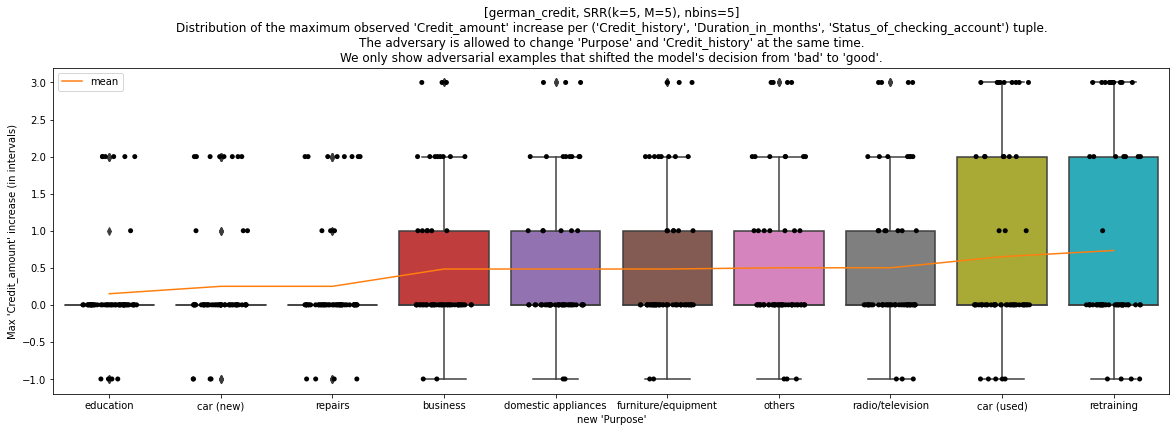

In [80]:
ax = sns.boxplot(x="new 'Purpose'", y="Max 'Credit_amount' increase (in intervals)", data=data, order=means.index)

sns.stripplot(x="new 'Purpose'", y="Max 'Credit_amount' increase (in intervals)", 
              data=data, ax=ax, color='k', jitter=0.25, order=means.index)

sns.lineplot(data=means, label='mean', ax=ax, color=sns.color_palette('tab10')[1])


ax.figure.set(size_inches=(20, 6))
ax.set_title(
    "[german_credit, SRR(k=5, M=5), nbins=5]\n"
    "Distribution of the maximum observed 'Credit_amount' increase per ('Credit_history', 'Duration_in_months', 'Status_of_checking_account') tuple.\n"
    "The adversary is allowed to change 'Purpose' and 'Credit_history' at the same time.\n"
    "We only show adversarial examples that shifted the model's decision from 'bad' to 'good'."
);

##### Plot of maximum Credit_amount increase while changing Duration_in_months

In [69]:
df = adversaries['original'].copy()
df['Duration change'] = adversaries['adversarial']['Duration_in_months'].map(month_map) \
                      - adversaries['original']['Duration_in_months'].map(month_map).astype(int)

df['Credit change'] = adversaries['adversarial']['Credit_amount'].map(amount_map) \
                    - adversaries['original']['Credit_amount'].map(amount_map).astype(int)


df.replace({'label': {0: 'bad -> good', 1: 'good -> bad'}}, inplace=True)
df

,Credit_amount,Credit_history,Duration_in_months,Purpose,Status_of_checking_account,label,Duration change,Credit change
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,-2,-3
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,-2,0
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,-2,-2
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,-2,-1
1,"(4053.0, inf]",existing credits paid back duly till now,"(29.0, inf]",radio/television,0 <= ... < 200 DM,bad -> good,-1,-3
...,...,...,...,...,...,...,...,...
998,"(1401.0, 2382.0]",existing credits paid back duly till now,"(29.0, inf]",radio/television,... < 0 DM,bad -> good,-3,-1
998,"(1401.0, 2382.0]",existing credits paid back duly till now,"(29.0, inf]",radio/television,... < 0 DM,bad -> good,-3,2
998,"(1401.0, 2382.0]",existing credits paid back duly till now,"(29.0, inf]",radio/television,... < 0 DM,bad -> good,-3,0
998,"(1401.0, 2382.0]",existing credits paid back duly till now,"(29.0, inf]",radio/television,... < 0 DM,bad -> good,-3,1


In [70]:
df = df[df.label == 'bad -> good'].groupby(['Duration change', 'Credit_history', 'Purpose', 'Status_of_checking_account']) \
                             .agg({'Credit change': 'max'})

In [75]:
data = df.reset_index().drop(columns=['Credit_history', 'Purpose', 'Status_of_checking_account'])

data['Duration change'] = data['Duration change'].astype(int)
data['Credit change'] = data['Credit change'].astype(int)

data.columns = ["'Duration_in_months' interval jumps", "Max 'Credit_amount' increase (in intervals)"]

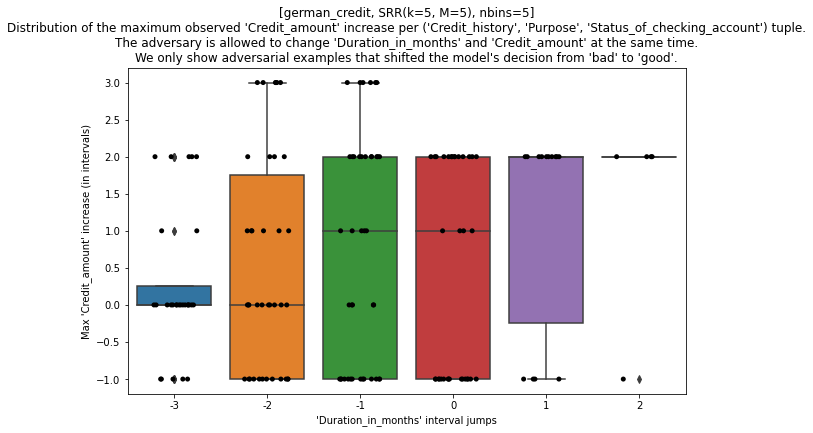

In [88]:
ax = sns.boxplot(x="'Duration_in_months' interval jumps", y="Max 'Credit_amount' increase (in intervals)", data=data)

sns.stripplot(x="'Duration_in_months' interval jumps", y="Max 'Credit_amount' increase (in intervals)", 
              data=data, ax=ax, color='k', jitter=0.25)

ax.figure.set(size_inches=(10, 6))
ax.set_title(
    "[german_credit, SRR(k=5, M=5), nbins=5]\n"
    "Distribution of the maximum observed 'Credit_amount' increase per ('Credit_history', 'Purpose', 'Status_of_checking_account') tuple.\n"
    "The adversary is allowed to change 'Duration_in_months' and 'Credit_amount' at the same time.\n"
    "We only show adversarial examples that shifted the model's decision from 'bad' to 'good'."
);

##### Plot of distribution of adversarial examples

In [35]:
def pretty_interval(interval):
    lo, hi = str(interval)[1:-1].split(', ')
    return f'{lo} < . <= {hi}'

In [36]:
def pretty_intervals(series):
    return series.map(pretty_interval).astype(str)

In [56]:
feats = 'Duration_in_months'

df = adversaries['original'].copy()
df['change'] = adversaries['adversarial'][feat].map(month_map) - adversaries['original'][feat].map(month_map).astype(int)

In [57]:
df = df.groupby(['label', 'change']).size().reset_index().rename(columns={0: 'count'})
df.replace({'label': {0: 'bad -> good', 1: 'good -> bad'}}, inplace=True)
df.columns = ['label change', 'interval jumps', 'count']
df.loc[(len(df.index))] = (np.nan, 0, 0)

In [58]:
df['interval jumps'] = df['interval jumps'].astype(int)
df

,label change,interval jumps,count
0,bad -> good,-4,32.0
1,bad -> good,-3,26.0
2,bad -> good,-2,26.0
3,bad -> good,-1,24.0
4,good -> bad,1,20.0
5,good -> bad,2,17.0
6,good -> bad,3,23.0
7,good -> bad,4,9.0
8,NaN,0,0.0


#### New plot (after feedback)

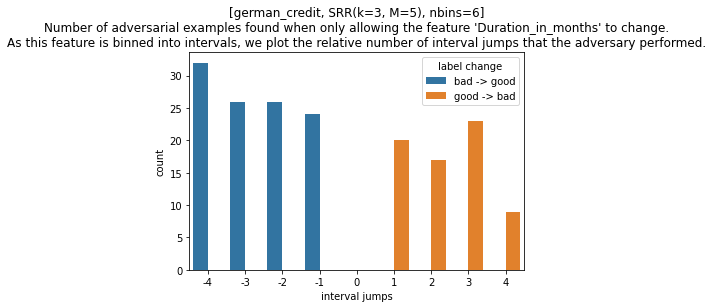

In [59]:
ax = sns.barplot(y='count', x='interval jumps', hue='label change', data=df)

ax.set_title(
    "[german_credit, SRR(k=3, M=5), nbins=6]\n"
    "Number of adversarial examples found when only allowing the feature 'Duration_in_months' to change.\n"
    "As this feature is binned into intervals, we plot the relative number of interval jumps that the adversary performed."
);

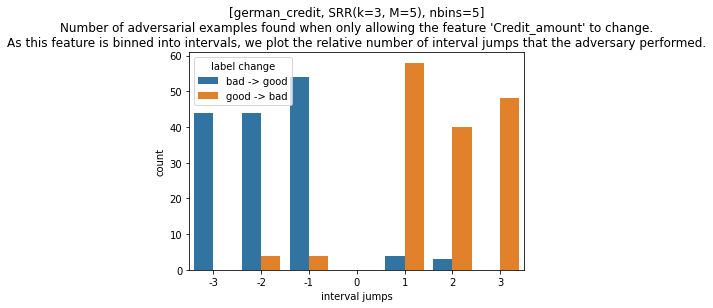

In [41]:
ax = sns.barplot(y='count', x='interval jumps', hue='label change', data=df)

ax.set_title(
    "[german_credit, SRR(k=3, M=5), nbins=5]\n"
    "Number of adversarial examples found when only allowing the feature 'Credit_amount' to change.\n"
    "As this feature is binned into intervals, we plot the relative number of interval jumps that the adversary performed."
);

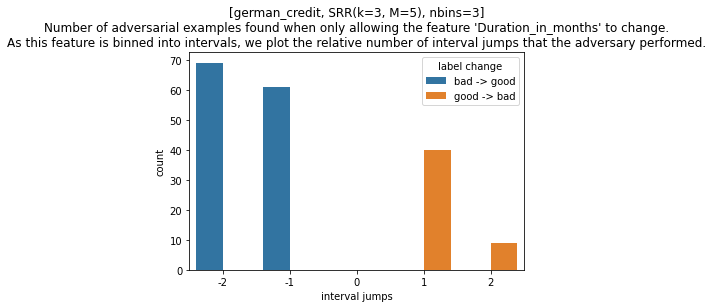

In [48]:
ax = sns.barplot(y='count', x='interval jumps', hue='label change', data=df)

ax.set_title(
    "[german_credit, SRR(k=3, M=5), nbins=3]\n"
    "Number of adversarial examples found when only allowing the feature 'Duration_in_months' to change.\n"
    "As this feature is binned into intervals, we plot the relative number of interval jumps that the adversary performed."
);

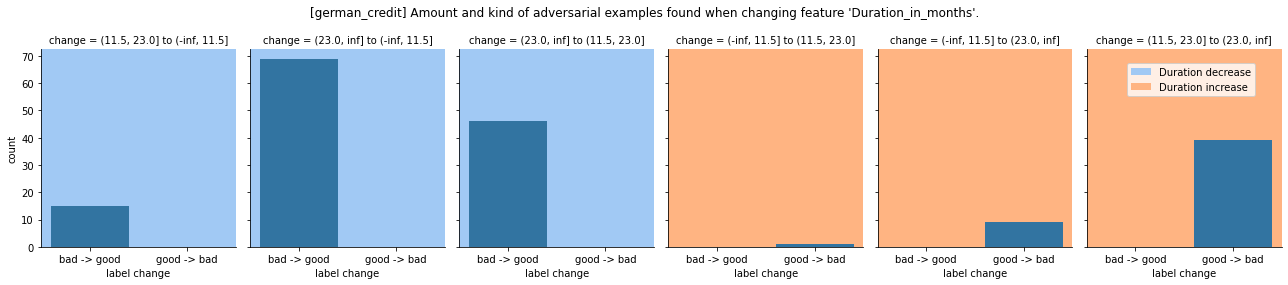

In [176]:
from matplotlib.patches import Patch

col1 = sns.color_palette('pastel')[0]
col2 = sns.color_palette('pastel')[1]
col3 = sns.color_palette('tab10')[0]

facet = sns.catplot(x='label change', y='count', col='change', kind='bar', data=df,
                    palette={'bad -> good': col3, 'good -> bad': col3})
for i in range(3):
    ax = facet.axes[0, i]
    ax.set_facecolor(col1)
for i in range(3, 6):
    ax = facet.axes[0, i]
    ax.set_facecolor(col2)

facet.fig.set_figheight(4)
facet.fig.set_figwidth(18)

handles = [Patch(facecolor=col1, label='Duration decrease'),
           Patch(facecolor=col2, label='Duration increase')]
facet.fig.legend(handles=handles, loc=1, bbox_to_anchor=(0.475, 0.3, 0.5, 0.5))

facet.fig.set_tight_layout(True)
facet.fig.suptitle("[german_credit] Amount and kind of adversarial examples found when changing feature 'Duration_in_months'.");

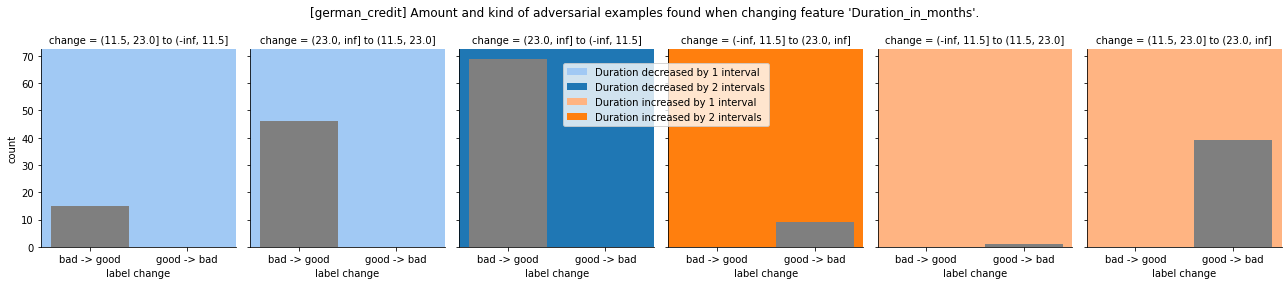

In [177]:
from matplotlib.patches import Patch

col1 = sns.color_palette('pastel')[0]
col2 = sns.color_palette('pastel')[1]
col1_d = sns.color_palette('tab10')[0]
col2_d = sns.color_palette('tab10')[1]
col3 = sns.color_palette('tab10')[7]

facet = sns.catplot(x='label change', y='count', col='change', kind='bar', data=df.iloc[[0, 2, 1, 4, 3, 5], :],
                    palette={'bad -> good': col3, 'good -> bad': col3})

facet.axes[0, 0].set_facecolor(col1)
facet.axes[0, 1].set_facecolor(col1)
facet.axes[0, 2].set_facecolor(col1_d)
facet.axes[0, 3].set_facecolor(col2_d)
facet.axes[0, 4].set_facecolor(col2)
facet.axes[0, 5].set_facecolor(col2)

facet.fig.set_figheight(4)
facet.fig.set_figwidth(18)

handles = [Patch(facecolor=col1, label='Duration decreased by 1 interval'),
           Patch(facecolor=col1_d, label='Duration decreased by 2 intervals'),
           Patch(facecolor=col2, label='Duration increased by 1 interval'),
           Patch(facecolor=col2_d, label='Duration increased by 2 intervals')]
facet.fig.legend(handles=handles, loc=1, bbox_to_anchor=(0.1, 0.3, 0.5, 0.5))

handles = []

facet.fig.set_tight_layout(True)
facet.fig.suptitle("[german_credit] Amount and kind of adversarial examples found when changing feature 'Duration_in_months'.");

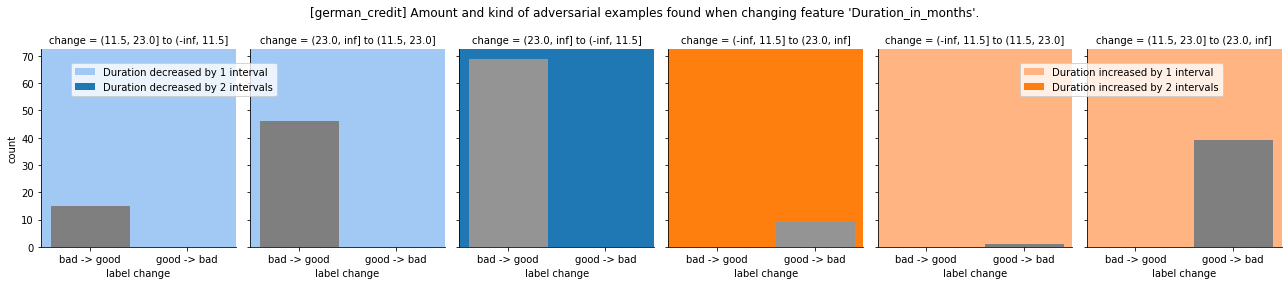

In [186]:
from matplotlib.patches import Patch

col1 = sns.color_palette('pastel')[0]
col2 = sns.color_palette('pastel')[1]
col1_d = sns.color_palette()[0]
col2_d = sns.color_palette()[1]
col3 = sns.color_palette('colorblind')[7]
col3_d = sns.color_palette()[7]

facet = sns.catplot(x='label change', y='count', col='change', kind='bar', data=df.iloc[[0, 2, 1, 4, 3, 5], :])

facet.axes[0, 0].set_facecolor(col1)
facet.axes[0, 0].get_children()[0].set_color(col3_d)
facet.axes[0, 1].set_facecolor(col1)
facet.axes[0, 1].get_children()[0].set_color(col3_d)
facet.axes[0, 2].set_facecolor(col1_d)
facet.axes[0, 2].get_children()[0].set_color(col3)
facet.axes[0, 3].set_facecolor(col2_d)
facet.axes[0, 3].get_children()[1].set_color(col3)
facet.axes[0, 4].set_facecolor(col2)
facet.axes[0, 4].get_children()[1].set_color(col3_d)
facet.axes[0, 5].set_facecolor(col2)
facet.axes[0, 5].get_children()[1].set_color(col3_d)

facet.fig.set_figheight(4)
facet.fig.set_figwidth(18)

handles = [Patch(facecolor=col1, label='Duration decreased by 1 interval'),
           Patch(facecolor=col1_d, label='Duration decreased by 2 intervals')]
facet.fig.legend(handles=handles, loc=1, bbox_to_anchor=(-0.28, 0.3, 0.5, 0.5))

handles = [Patch(facecolor=col2, label='Duration increased by 1 interval'),
           Patch(facecolor=col2_d, label='Duration increased by 2 intervals')]
facet.fig.legend(handles=handles, loc=1, bbox_to_anchor=(0.45, 0.3, 0.5, 0.5))

handles = []

facet.fig.set_tight_layout(True)
facet.fig.suptitle("[german_credit] Amount and kind of adversarial examples found when changing feature 'Duration_in_months'.");

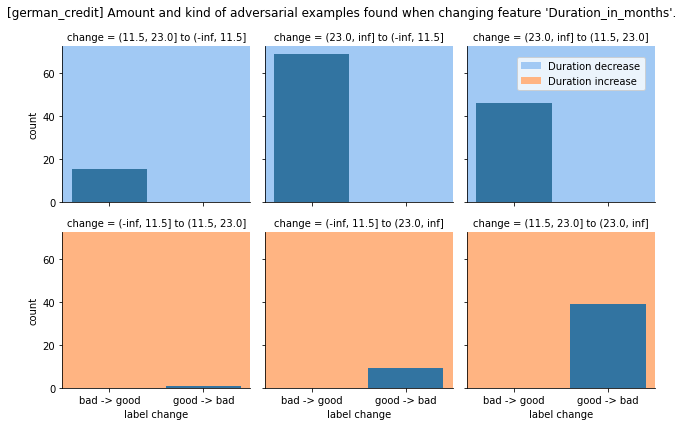

In [188]:
from matplotlib.patches import Patch

col1 = sns.color_palette('pastel')[0]
col2 = sns.color_palette('pastel')[1]
col3 = sns.color_palette('tab10')[0]

facet = sns.catplot(x='label change', y='count', col='change', kind='bar', data=df, col_wrap=3,
                    palette={'bad -> good': col3, 'good -> bad': col3})

for i in range(3):
    ax = facet.axes[i]
    ax.set_facecolor(col1)
for i in range(3, 6):
    ax = facet.axes[i]
    ax.set_facecolor(col2)

facet.fig.set_figheight(6)
facet.fig.set_figwidth(9)

handles = [Patch(facecolor=col1, label='Duration decrease'),
           Patch(facecolor=col2, label='Duration increase')]
facet.fig.legend(handles=handles, loc=1, bbox_to_anchor=(0.475, 0.375, 0.5, 0.5))

facet.fig.set_tight_layout(True)
facet.fig.suptitle("[german_credit] Amount and kind of adversarial examples found when changing feature 'Duration_in_months'.");

In [23]:
table = df.pivot_table(index='label', columns='change', values='count').replace({np.nan: 0}).astype(int)

In [120]:
table.iloc[:, [0, 1, 3, 2, 4, 5]]

change,"(-inf, 11.5] -> (11.5, 23.0]","(-inf, 11.5] -> (23.0, inf]","(11.5, 23.0] -> (23.0, inf]","(11.5, 23.0] -> (-inf, 11.5]","(23.0, inf] -> (-inf, 11.5]","(23.0, inf] -> (11.5, 23.0]"
label,,,,,,
bad -> good,15,69,46,0,0,0
good -> bad,0,0,0,1,9,39


## Plot of change accross different feature combinations

In [32]:
change = 'Duration_in_months'
others = sorted(list(set(model.df.index.levels[0]) - {'bias', change}))

df = adversaries['adversarial'].copy()
df = df[df.label == 1].drop(columns='label')

fd = adversaries['original'].copy()
fd = fd[fd.label == 0].drop(columns='label')

df['change'] = df[change].replace(month_map) - fd[change].replace(month_map)

df = df.groupby(others + ['change']).size().rename('amount').reset_index()

# Add extra zeroed-entries with changes 0, 1 and 2 so that these values appear on the graph
df.loc[12] = (df.loc[0, 'Credit_history'], df.loc[0, 'Status_of_checking_account'], 0, 0)
df.loc[13] = (df.loc[0, 'Credit_history'], df.loc[0, 'Status_of_checking_account'], 1, 0)
df.loc[14] = (df.loc[0, 'Credit_history'], df.loc[0, 'Status_of_checking_account'], 2, 0)

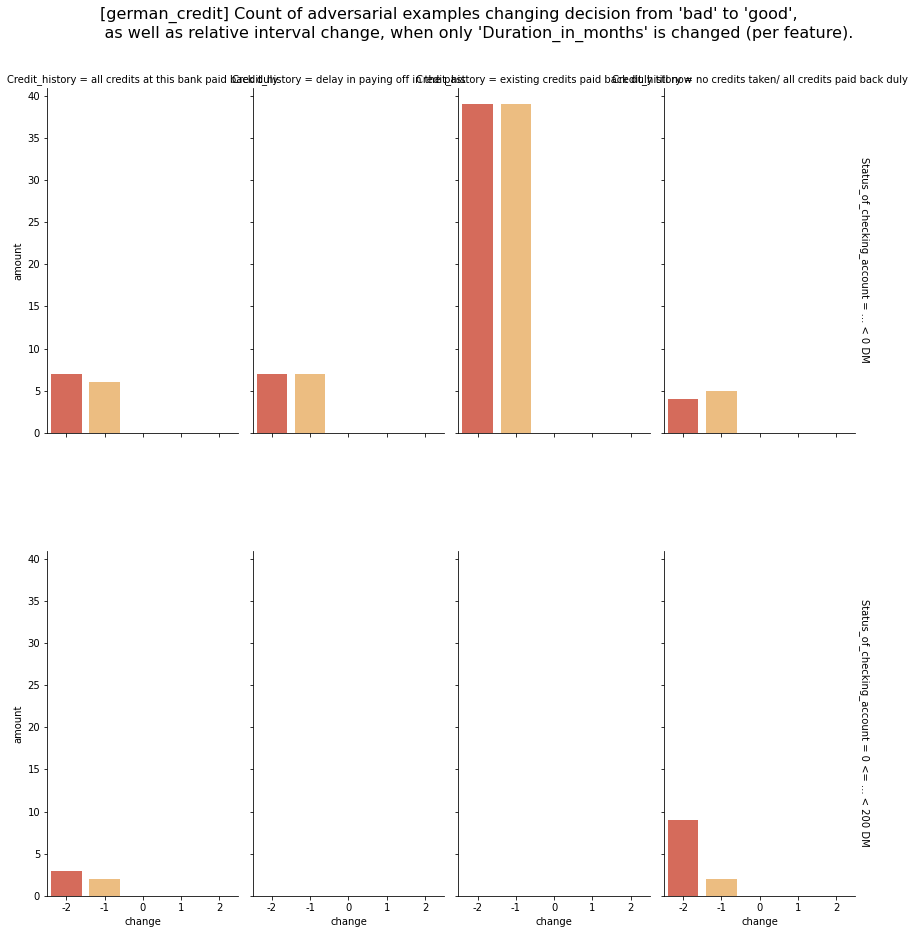

In [35]:
ax = sns.catplot(x='change', y='amount',
                 col=others[0],
                 row=others[1],
                 data=df,
                 margin_titles=True,
                 height=3,
                 kind='bar',
                 palette='Spectral')

ax.fig.set_figheight(14)
plt.subplots_adjust(top=0.9)
ax.fig.suptitle(f"""[german_credit] Count of adversarial examples changing decision from 'bad' to 'good',
            as well as relative interval change, when only '{change}' is changed (per feature).""", size=16);

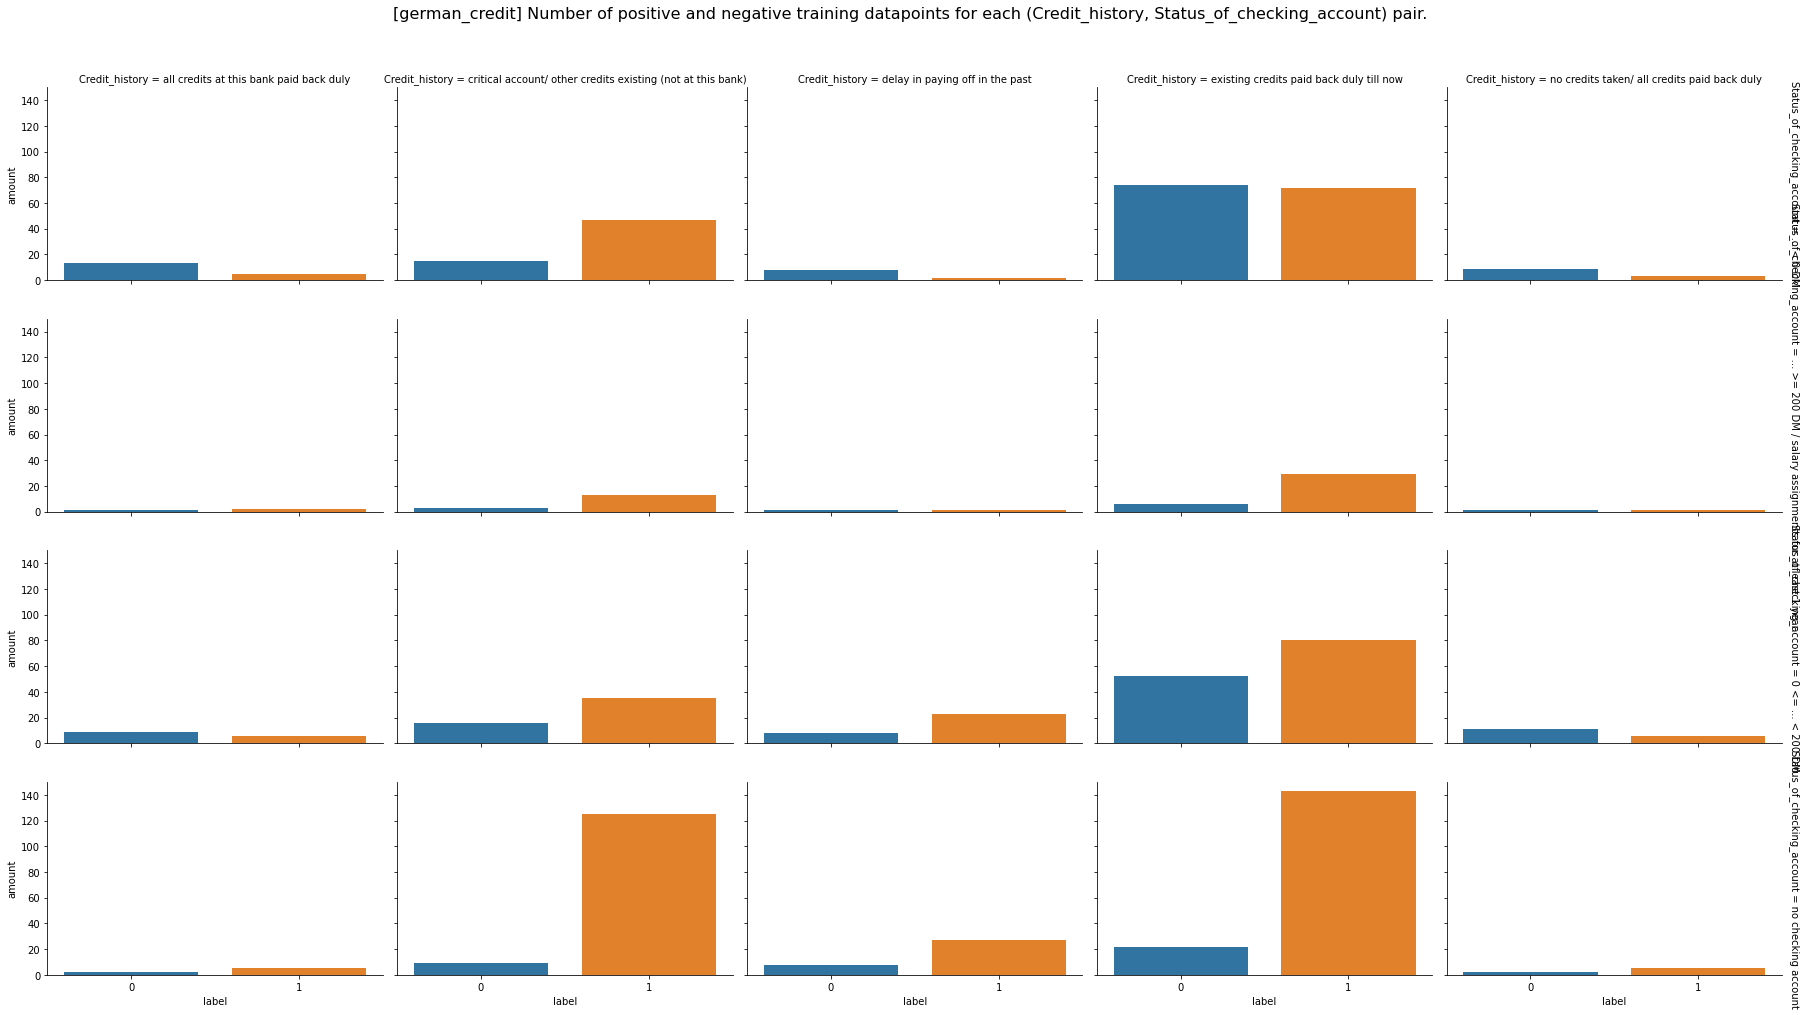

In [23]:
train = X_train_bin.copy()
train['label'] = y_train

ax = sns.catplot(x='label', y='amount',
                 col=others[0],
                 row=others[1],
                 data=train.groupby(['label'] + others).size().rename('amount').reset_index(),
                 margin_titles=True,
                 height=5,
                 kind='bar')


ax.fig.set_figheight(14)
plt.subplots_adjust(top=0.9)
ax.fig.suptitle(f"[german_credit] Number of positive and negative training datapoints for each (Credit_history, Status_of_checking_account) pair.", size=16);

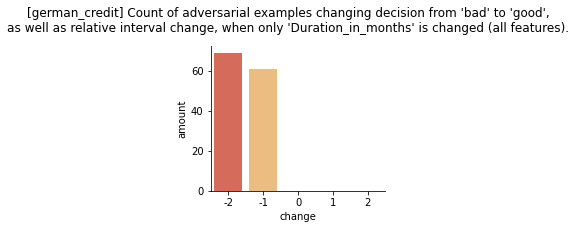

In [13]:
ax = sns.catplot(x='change', y='amount',
            data=df.groupby('change')[['amount']].sum().reset_index(),
            margin_titles=True, height=3, kind='bar',
            palette='Spectral')

plt.subplots_adjust(top=0.8)
ax.fig.suptitle(f"[german_credit] Count of adversarial examples changing decision from 'bad' to 'good',\nas well as relative interval change, when only '{can_change}' is changed (all features).", size=12);

In [16]:
def show_adversarial_changes_and_counts(model, X, y, can_change):
    """
    Finds adversaries for the model, and plots them.
    Only works if the k of the model is 3.
    Unlike in find_adversarial_examples, can_change is not a list but a single feature name.
    """
    adversaries = find_adversarial_examples(model, X_train_bin, y_train, [can_change], unit_changes=True)
    
    all_feats = list(model.df.index.levels[0])
    all_feats.remove('bias')
    others = all_feats
    others.remove(can_change)
    
    df = adversaries['adversarial'].copy()
    df['change'] = df[can_change].replace(interval_mapping) \
                - adversaries['original'][can_change].replace(interval_mapping).astype(int)
    
    # Create dataframe with data in a good format
    zero_to_one = df[df['label'] == 1]
    zero_to_one = zero_to_one.groupby(others + ['change']).size().rename('amount').reset_index()
    zero_to_one['kind'] = '0 -> 1'

    one_to_zero = df[df['label'] == 0]
    one_to_zero = one_to_zero.groupby(others + ['change']).size().rename('amount').reset_index()
    one_to_zero['kind'] = '1 -> 0'

    data = pd.concat([zero_to_one, one_to_zero])
    
    # Plot
    ax = sns.catplot(x='kind', y='amount',
            col=others[0],
            row=others[1],
            hue='change',
            data=data, margin_titles=True, height=3, kind='bar',
            palette='Spectral')
    
    plt.subplots_adjust(top=0.9)
    ax.fig.suptitle(f"Count of adversarial examples (and their kind) when only '{can_change}' is changed");

100%|██████████| 667/667 [00:04<00:00, 143.72it/s]


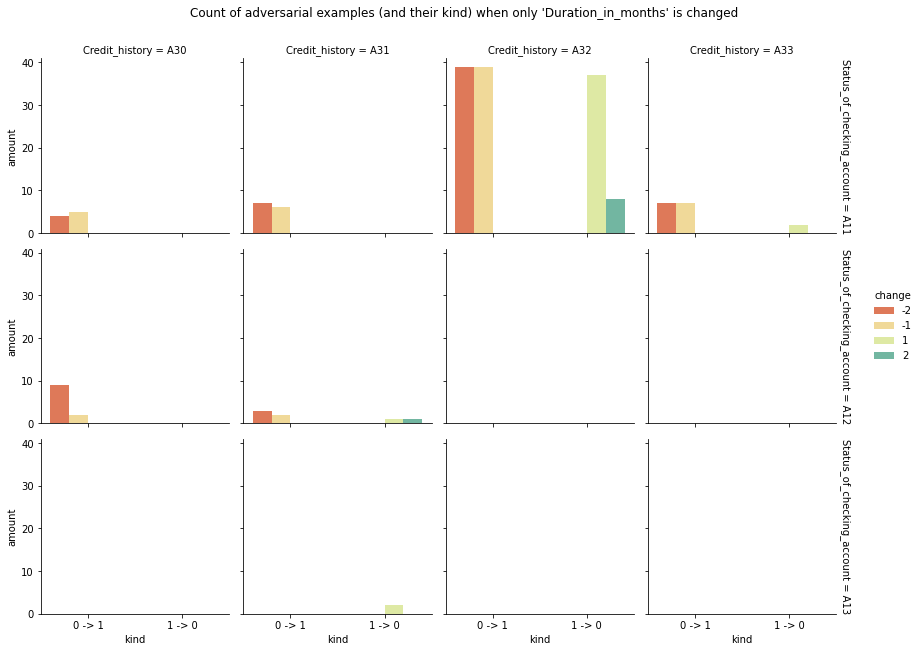

In [17]:
show_adversarial_changes_and_counts(model, X_train_bin, y_train, can_change='Duration_in_months')

In [18]:
def show_adversaries_and_counts(model, X, y, can_change):
    """
    Finds adversaries for the model, and plots them.
    Only works if the k of the model is 3.
    Unlike in find_adversarial_examples, can_change is not a list but a single feature name.
    """
    adversaries = find_adversarial_examples(model, X_train_bin, y_train, [can_change], unit_changes=True)
    
    all_feats = list(model.df.index.levels[0])
    all_feats.remove('bias')
    
    # Create dataframe with data in a good format
    zero_to_one = adversaries['adversarial'][adversaries['adversarial']['label'] == 1]
    zero_to_one = zero_to_one.groupby(all_feats).size().rename('amount').reset_index()
    zero_to_one['kind'] = '0 -> 1'

    one_to_zero = adversaries['adversarial'][adversaries['adversarial']['label'] == 0]
    one_to_zero = one_to_zero.groupby(all_feats).size().rename('amount').reset_index()
    one_to_zero['kind'] = '1 -> 0'

    data = pd.concat([zero_to_one, one_to_zero])
    
    others = all_feats
    others.remove(can_change)
    
    # Plot
    ax = sns.catplot(x='kind', y='amount',
            col=others[0],
            row=others[1],
            hue=can_change,
            data=data, margin_titles=True, height=3, kind='bar')
    
    plt.subplots_adjust(top=0.9)
    ax.fig.suptitle(f"Count of adversarial examples (and their kind) when only '{can_change}' is changed");

100%|██████████| 667/667 [00:04<00:00, 137.60it/s]


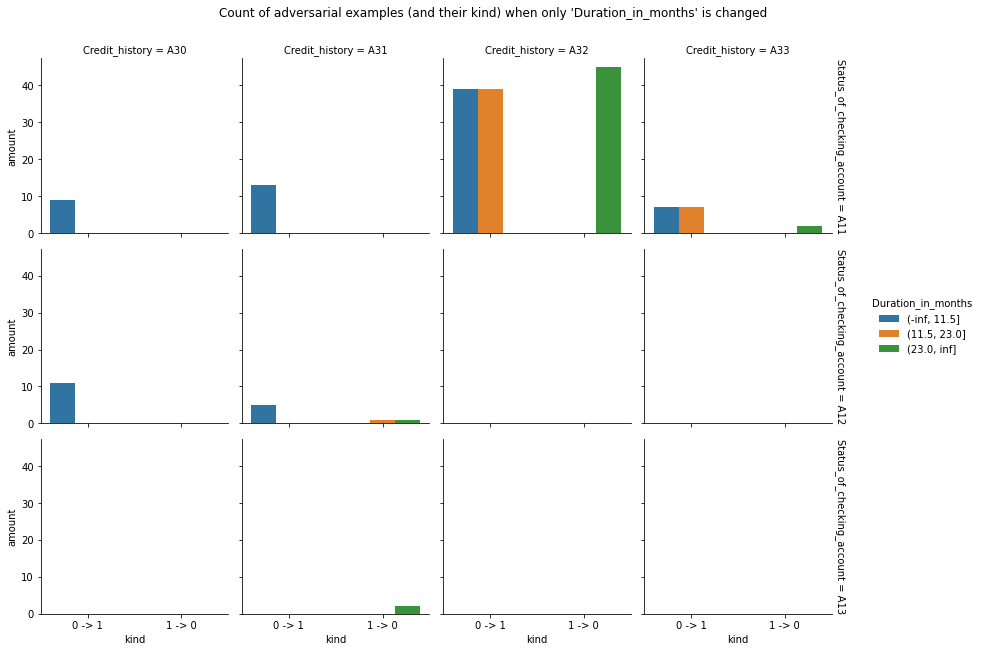

In [19]:
show_adversaries_and_counts(model, X_train_bin, y_train, "Duration_in_months")